# Домашняя работа 1.
Дедлайн - 26 февраля 23:59 по МСК (GMT+3).

Сдавать в [классрум](https://classroom.google.com/c/NjYxNjY4MjY3NDIw?cjc=pho754c)

## Задача 1. (3 балла)
Реализуйте метод решения системы линейных уравнений при помощи метода Гаусса, LU-разложения.
Используя функцию для генерации случайной системы линейных уравнений, протестируйте написанную Вами программу. 

Данная функция генерирует матрицу системы $A$, правую часть $y$ и решение $x$:
$$
Ax = y
$$
для любой наперед заданной размерности линейного пространства $n$.

Рассмотрите случаи $n = 10, 30, 100, 300, 1000$. Для нескольких реализаций $m$, например, $m = 10, A_i , x_i , y_i$ для $i = 1, ..., m$ решите систему уравнений при помощи
написанной Вами программы. Для каждой реализации вычислите ошибку:
$$
r_i = \max_j|x_{i, j} - x_{i, j}^*|
$$
Здесь $x_i = [x_{i, 1}, ..., x_{i, n}]^\top$ - решение системы линейных уравнений, $x_i^*=[x_{i, 1}^*, ..., x_{i, n}^*]^\top$ - численное решение системы линейных уравнений.

Для каждого значения размерности $n$ вычислите максимальную ошибку по всем
реализациям систем линейных уравнений:
$$
R(n) = \max_{i=1,..., m}(r_i)
$$
Постройте таблицу значений $n$ и $R(n)$ (или просто выведите на экран).
Рассмотрите случаи $n = 10, 30, 100, 300, 1000$. Постройте график (в логарифмическом масштабе) $t = t(n)$ - время решения системы линейных уравнений как функция
размерности.

In [35]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from numba import jit
import time

### СЛУ Генератор

In [10]:
def generate_l_matrix(n):
    eps = 2.0e+0
    lmat = np.zeros((n, n))
    lmat = np.random.normal(0.0, 5.0e-1, (n, n))
    for i0 in range(n):
        lmat[i0, i0] = np.absolute(lmat[i0, i0]) + eps
        for i1 in range(i0 + 1, n):
            lmat[i0, i1] = 0.0
    return lmat

def generate_u_matrix(n):
    return np.transpose(generate_l_matrix(n))

def generate_sle(n):
    A = np.dot(generate_l_matrix(n), generate_u_matrix(n))
    x = np.random.normal(0.0, 1.0, n)
    y = np.dot(A, x)
    return A, y, x

### Метод Гаусса

In [23]:
def gauss_method(A, y):
    n = len(y)
    matrix = np.column_stack((A, y))

    for i in range(n):
        pivot_row = matrix[i]
        for j in range(i + 1, n):
            factor = matrix[j][i] / pivot_row[i]
            matrix[j] -= factor * pivot_row

    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = matrix[i][-1] / matrix[i][i]
        matrix[:i, -1] -= matrix[:i, i] * x[i]

    return x

### LU-Разложение

In [41]:
@jit(nopython=True, fastmath=True)
def compute_lu_factorization(amat):
    n = amat.shape[0]
    lmat = np.zeros((n, n))
    umat = np.eye(n)
    for idx_row in range(n):
        for idx_col in range(idx_row + 1):
            lmat[idx_row, idx_col] = (amat[idx_row, idx_col] - np.dot(lmat[idx_row, :idx_col], umat[:idx_col, idx_col])) / umat[idx_col, idx_col]
        for idx_col in range(idx_row + 1, n):
            umat[idx_row, idx_col] = (amat[idx_row, idx_col] - np.dot(lmat[idx_row, :idx_row], umat[:idx_row, idx_col])) / lmat[idx_row, idx_row]
    return (lmat, umat)

@jit(nopython=True, fastmath=True)
def solve_l_system(lmat, y):
    n = y.size
    x = np.zeros((n))
    for idx in range(n):
        x[idx] = (y[idx] - np.dot(lmat[idx, :idx], x[:idx])) / lmat[idx, idx]
    return x

@jit(nopython=True, fastmath=True)
def solve_u_system(umat, y):
    n = y.size
    x = np.zeros((n))
    for idx in range(n):
        k = n - 1 - idx
        x[k] = (y[k] - np.dot(umat[k, (k + 1):], x[(k + 1):])) / umat[k, k]
    return x

def lu_method(A, y):
    lmat, umat = compute_lu_factorization(A)
    zvec = solve_l_system(lmat, y)
    xvec = solve_u_system(umat, zvec)
    return xvec

### Тесты

Размер СЛУ (n)  | Максимальная ошибка (R(n))
10              | 1.3322676295501878e-15
30              | 4.440892098500626e-15
100             | 2.2071233729548112e-13
300             | 4.592497196767575e-09
1000            | 12133.104173710013


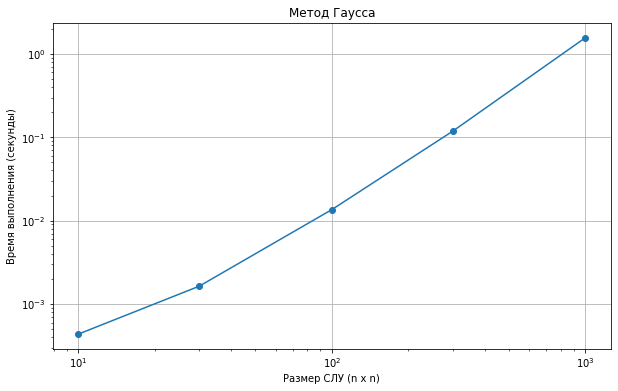

In [39]:
# Функция для вычисления ошибки
def compute_error(x, x_star):
    return np.max(np.abs(x - x_star))

# Функция для измерения времени выполнения метода
def measure_time(method, A, y):
    start_time = time.time()
    x = method(A, y)
    end_time = time.time()
    return x, end_time - start_time

sizes = [10, 30, 100, 300, 1000]
m = 10

max_errors = {}
execution_times = {}

for n in sizes:
    errors = []
    times = []
    
    for i in range(m):
        A, y, x_star = generate_sle(n)
        x, time_taken = measure_time(gauss_method, A.copy(), y.copy())
        errors.append(compute_error(x, x_star))
        times.append(time_taken)
    
    max_errors[n] = np.max(errors)
    execution_times[n] = np.mean(times)

# Выводим таблицу значений размера системы и максимальной ошибки
print("Размер СЛУ (n)  | Максимальная ошибка (R(n))")
for n in sizes:
    print(f"{n:<15} | {max_errors[n]}")

# Строим график времени выполнения в логарифмическом масштабе
plt.figure(figsize=(10, 6))
plt.plot(sizes, list(execution_times.values()), marker='o')
plt.title("Метод Гаусса")
plt.xlabel("Размер СЛУ (n x n)")
plt.ylabel("Время выполнения (секунды)")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

Размер СЛУ (n)  | Максимальная ошибка (R(n))
10              | 4.996003610813204e-16
30              | 3.552713678800501e-15
100             | 1.179889519420385e-13
300             | 2.9753256525211214e-09
1000            | 786.2064326861338


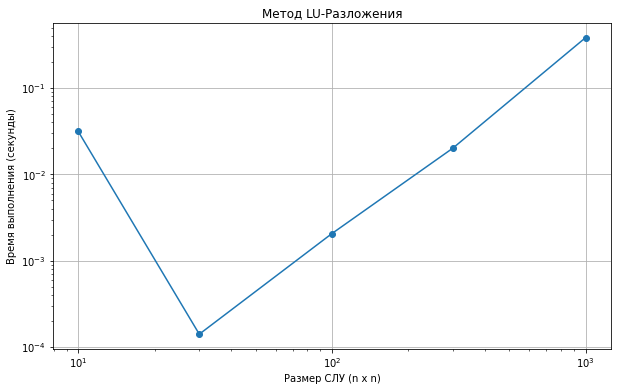

In [42]:
# Функция для вычисления ошибки
def compute_error(x, x_star):
    return np.max(np.abs(x - x_star))

# Функция для измерения времени выполнения метода
def measure_time(method, A, y):
    start_time = time.time()
    x = method(A, y)
    end_time = time.time()
    return x, end_time - start_time

sizes = [10, 30, 100, 300, 1000]
m = 10

max_errors = {}
execution_times = {}

for n in sizes:
    errors = []
    times = []
    
    for i in range(m):
        A, y, x_star = generate_sle(n)
        x, time_taken = measure_time(lu_method, A.copy(), y.copy())
        errors.append(compute_error(x, x_star))
        times.append(time_taken)
    
    max_errors[n] = np.max(errors)
    execution_times[n] = np.mean(times)

# Выводим таблицу значений размера системы и максимальной ошибки
print("Размер СЛУ (n)  | Максимальная ошибка (R(n))")
for n in sizes:
    print(f"{n:<15} | {max_errors[n]}")

# Строим график времени выполнения в логарифмическом масштабе
plt.figure(figsize=(10, 6))
plt.plot(sizes, list(execution_times.values()), marker='o')
plt.title("Метод LU-Разложения")
plt.xlabel("Размер СЛУ (n x n)")
plt.ylabel("Время выполнения (секунды)")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()